In [14]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV, CalibrationDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [ ]:
# load models
mdl_path = 'cv_results'
data_path = 'experiment'

feature_sets = [
    '30_phenotypes',
    '30_aggregate',
    '20_latest+demo',
    '30_latest+demo+phenotypes',
    '20_latest+demo+aggregate',
    '60_all'
]

model_names = [
    'RF',
    'LR',
    'EBM',
    'GFN',
    'XGB',
    'TNET',
    'DT'
]

n = 10
res = []

for fs in feature_sets:

    print(fs)

    X_train = pd.read_csv(f'{data_path}/{fs}/X_train.csv', index_col=0)
    y_train = pd.read_csv(f'{data_path}/{fs}/y_train.csv', index_col=0)
    X_test = pd.read_csv(f'{data_path}/{fs}/X_test.csv', index_col=0)
    y_test = pd.read_csv(f'{data_path}/{fs}/y_test.csv', index_col=0)

    for mn in model_names:

        print(mn)
        
        models = pickle.load(open(f'{mdl_path}/saved_fitted_{fs}_{mn}_cv_models.pkl', 'rb'))

        for i in range(len(models)):

            model = CalibratedClassifierCV(models[i], cv="prefit")
            
            if mn == 'TNET':
                model.fit(X_train.values, y_train.values)
                y_pred = model.predict_proba(X_test.values)[:,1]
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict_proba(X_test)[:,1]
            fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred, n_bins=n) #, strategy='quantile'
            res.append({
                'model': mn,
                'feature_set': fs,
                'fold': i,
                'fraction_of_positives': fraction_of_positives,
                'mean_predicted_value': mean_predicted_value,
                'predictions': y_pred
            })

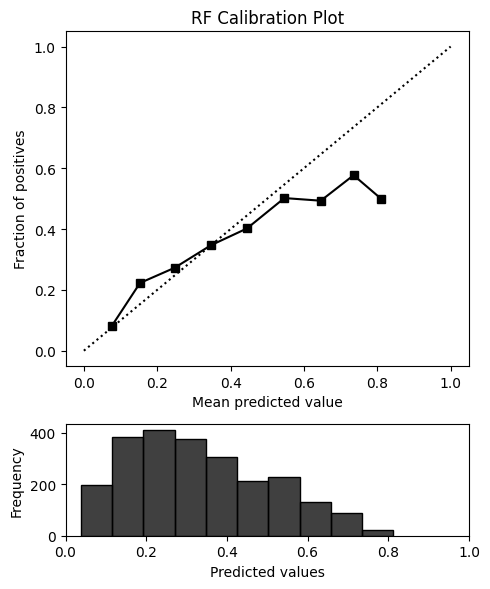

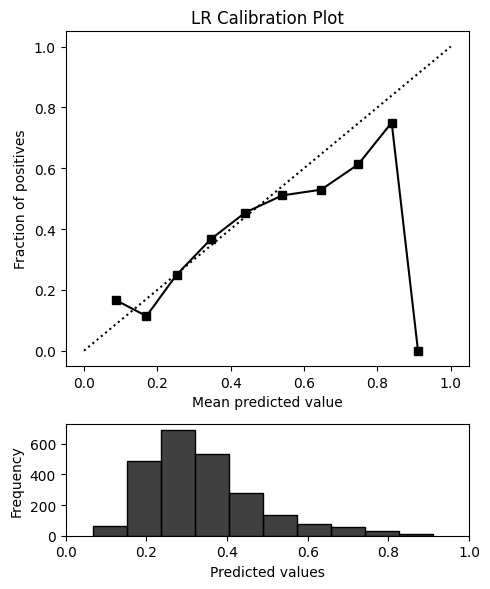

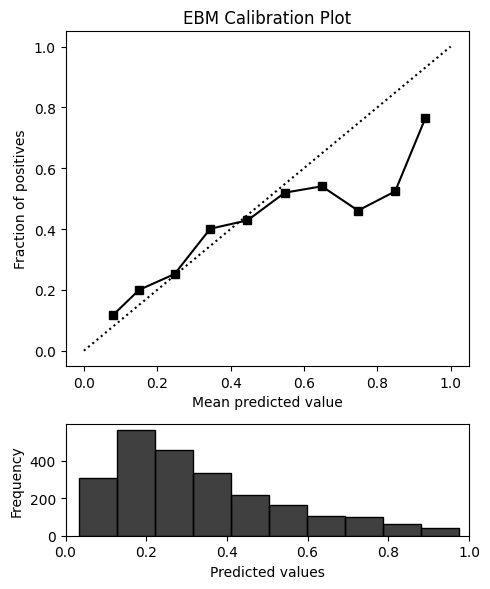

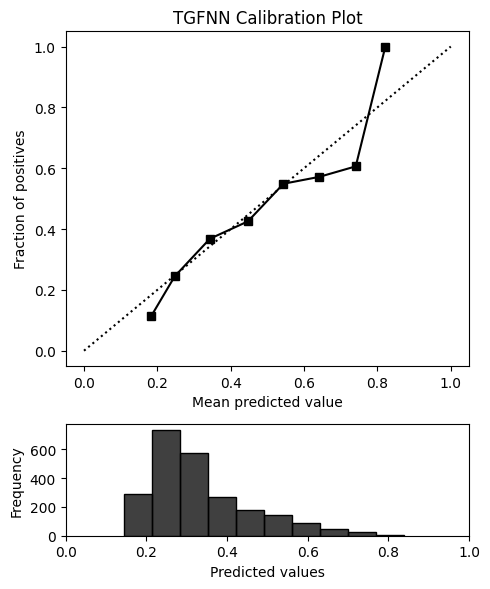

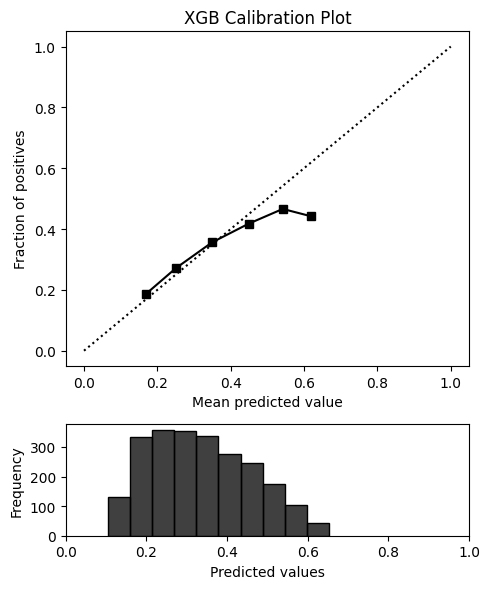

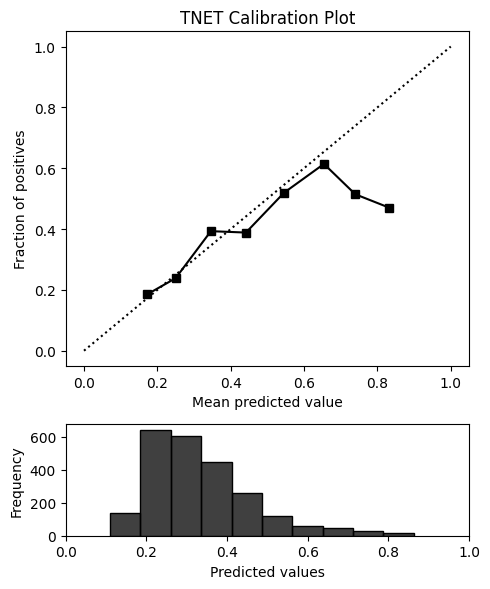

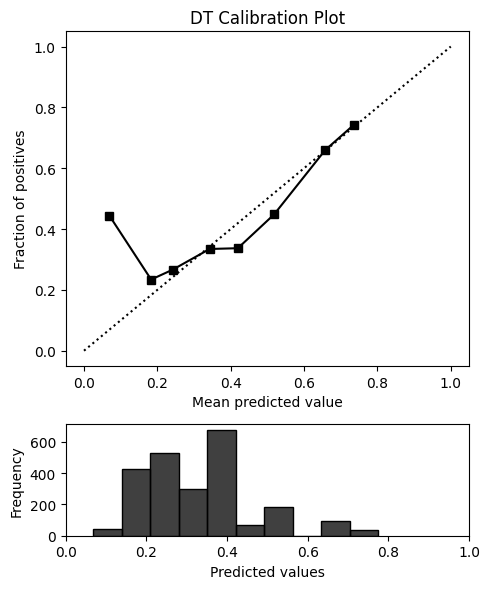

In [136]:
best_folds = { # identified in 4_tables_figures.ipynb
    'DT': 3,
    'EBM': 3,
    'LR': 3,
    'RF': 1,
    'GFN': 1,
    'TNET': 0,
    'XGB': 2
}

for mn in model_names:
    fold_counter = -1
    for r in res:
        if r['feature_set'] == '60_all':
            if r['model'] == mn:
                fold_counter += 1

                if fold_counter == best_folds[mn]:
                    if mn == 'GFN':
                        mn = 'TGFNN'

                    # Create a figure with two subplots stacked vertically
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6), gridspec_kw={'height_ratios': [3, 1]})

                    # Calibration plot
                    disp = CalibrationDisplay.from_predictions(y_test, r['predictions'], n_bins=10, name=mn, ax=ax1, color='black')
                    ax1.set_xlabel('Mean predicted value')
                    ax1.set_ylabel('Fraction of positives')
                    ax1.legend().remove()
                    ax1.set_title(f'{mn} Calibration Plot')

                    # Histogram plot
                    sns.histplot(r['predictions'], bins=10, ax=ax2, color='black')
                    ax2.set_xlim(0, 1)
                    ax2.set_xlabel('Predicted values')
                    ax2.set_ylabel('Frequency')

                    # Save the figure
                    plt.tight_layout()
                    plt.savefig(f'calibration_plot_{mn}.png', dpi=300)
                    # plt.show()
